## Question 2: Animal classification (15 marks)

For this question, we will use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals.

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 224 pixels wide by 224 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories.

We provide baseline code that includes the following features:

*   Loading and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.

The following changes could be considered:

1. "Transfer" Learning (ie use a model pre-trained another dataset)
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
3. Use of a new loss function.
4. Data augmentation
5. Architectural Changes: Batch Normalization, Residual layers, etc.
6. Others - please ask us on the Discussion Forums if you're not sure about an idea!

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

### Marking Rules:

We will mark this question based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark

**Acc_mark 10:**

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

**Efficiency mark 10:**

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

**Report mark 30:**

Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]



In [ ]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2023
### Student Name: ABC, XYZ
### Student ID: a123456, a654321
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC:         FLOPs:
##################################################################################################################################

In [ ]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
from google.colab import drive
drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/dataset/dataset/'
classes = os.listdir(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])


In [ ]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [ ]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [ ]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  ailurus-fulgens (5)


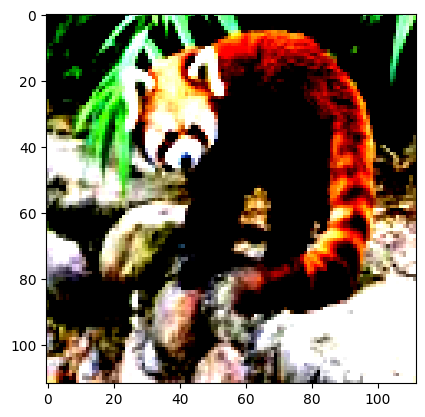

In [ ]:
show_image(*dataset[200])

In [ ]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [ ]:
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(5330, 313, 627)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

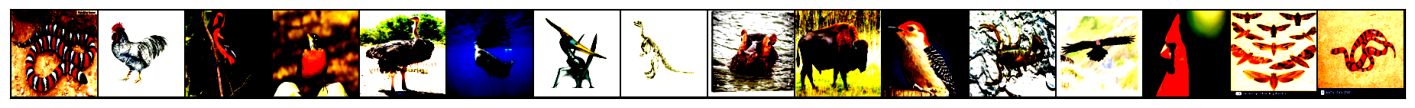

In [ ]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [ ]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*112*112
output_size = 151

In [ ]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)

        return F.log_softmax(X, dim=1)

In [ ]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
model.cuda()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [ ]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-5.0253, -5.0075, -4.9627, -5.0596, -5.0815, -4.9866, -5.0008, -4.9870,
        -5.0678, -5.0146, -5.0684, -4.9802, -4.9810, -5.0258, -5.0535, -5.0307,
        -5.0418, -5.0117, -5.0337, -5.0770, -5.0106, -5.0112, -5.0253, -4.9587,
        -4.9998, -4.9620, -4.9563, -5.0806, -5.0266, -4.9681, -4.9688, -5.0341,
        -5.0871, -5.0054, -5.0148, -4.9946, -5.0253, -4.9978, -4.9086, -5.0187,
        -5.0609, -5.0372, -5.0035, -5.0826, -4.9326, -5.0396, -5.0156, -5.0929,
        -5.0151, -5.0075, -5.0279, -5.0491, -4.9886, -5.0747, -5.0234, -5.0762,
        -5.0536, -5.0433, -5.0373, -4.9688, -5.0567, -5.0227, -5.0481, -5.0432,
        -5.0580, -4.9815, -5.0384, -5.0471, -5.0285, -5.0213, -5.0451, -5.0055,
        -5.0277, -5.0750, -5.0670, -5.0840, -5.0346, -4.9949, -5.0220, -4.9649,
        -5.0837, -5.0014, -5.0467, -4.9690, -4.9925, -4.9640, -5.0435, -5.0278,
        -5.0357, -5.0496, -5.0517, 

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [ ]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(model, device)

In [ ]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.015639781951904, 'val_acc': 0.02187499962747097}]

In [ ]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

627


In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.7622, val_loss: 4.5044, val_acc: 0.1198


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.2001, val_loss: 4.1664, val_acc: 0.2160


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.7232, val_loss: 4.0007, val_acc: 0.2559


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.2944, val_loss: 3.8822, val_acc: 0.3090


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.8404, val_loss: 3.8845, val_acc: 0.3222


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.4063, val_loss: 3.9011, val_acc: 0.3559


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.0362, val_loss: 3.9958, val_acc: 0.3747


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.6761, val_loss: 4.5315, val_acc: 0.3708


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.3672, val_loss: 4.9853, val_acc: 0.3441


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.1265, val_loss: 5.1909, val_acc: 0.3771


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

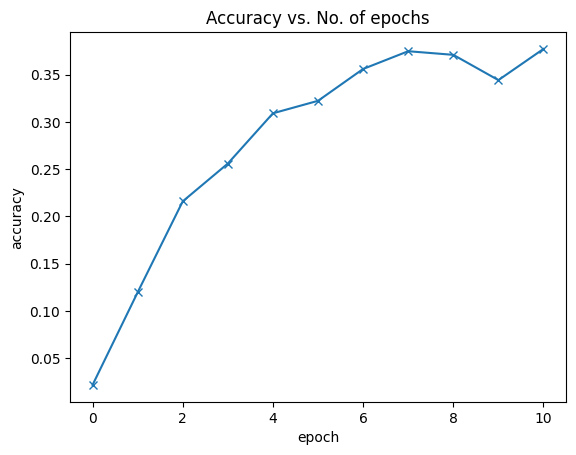

In [ ]:
plot_accuracies(history)

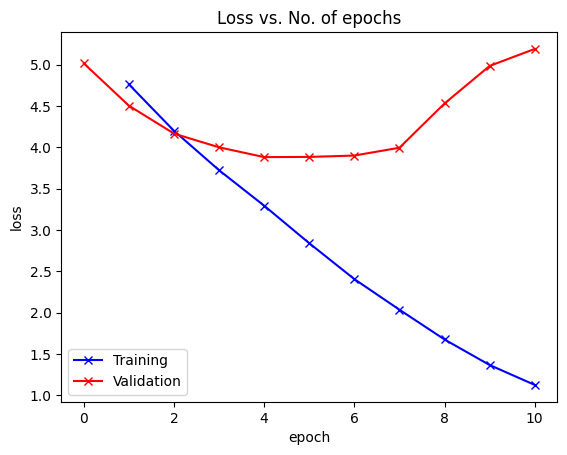

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 10.066055297851562, 'val_acc': 0.37447917461395264}

##FLOPs

In [ ]:
  #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
  !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  !mv download FLOPs_counter.py
  #!rm -rf download

--2023-08-02 13:25:26--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=bkv4f6nqi39akhpmt4iu04dfr8; path=/plus; domain=.aarnet.edu.au;; Secure; SameSite=Lax at position 76.
Syntax error in Set-Cookie: oc_sessionPassphrase=Y8JkoJB%2Bd0VLCZIVifKqLEBuZ3vlV5Be4Ic8TROb0jEJE%2Ftk%2BLwm5oKryx5gFKS5GvPLO48saYoxTQO4TjO%2F%2BnTGOQrf4CGTOQMlG12BAJdiQ9LGiGbBE8GkAW55R4z1; expires=Thu, 03-Aug-2023 13:25:28 GMT; Max-Age=86400; path=/plus;; Secure; SameSite=Lax at position 226.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2023-08-02 13:25:29 (1.71 GB/s) - ‘download’ saved [5201/5201]



In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.69G


In [ ]:
#My first model
#set data transform,make some changes
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=30),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])
dataset = ImageFolder(data_dir, transform=train_transform)
#set random seed
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)
#set batch,make a change
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
#We do not change the accuracy method to ensure we can compare with baseline model
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)
#This is where we define the loss function,the baseline use cross entropy，we won't change it since CE is a good loss function
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels, (5))
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
#use GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
input_size = 3*112*112
output_size = 151

In [ ]:
#CNN model,make some changes
from torch.nn import BatchNorm2d
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.bn1=BatchNorm2d(64)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.bn2=BatchNorm2d(128)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.conv5=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*3*3,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=self.bn1(X)
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=self.bn2(X)
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv5(X))
        X=X.view(-1,128*3*3)
        X=self.fc1(X)
        return F.log_softmax(X, dim=1)
num_classes = 151
model = ConvolutionalNetwork(num_classes)
model.cuda()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=151, bias=True)
)

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=151, bias=True)
)

In [ ]:
#Evacuation and training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [ ]:
model = to_device(model, device)
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.016951084136963, 'val_acc': 0.03437500074505806}]

In [ ]:
#train the model
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.8850, val_loss: 4.7836, val_acc: 0.0611


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.6062, val_loss: 4.6199, val_acc: 0.0932


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.4259, val_loss: 4.4801, val_acc: 0.1280


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.2658, val_loss: 4.5028, val_acc: 0.1552


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.1074, val_loss: 4.4407, val_acc: 0.1472


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.9751, val_loss: 4.2759, val_acc: 0.1990


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.8128, val_loss: 4.3128, val_acc: 0.2271


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.6703, val_loss: 4.1639, val_acc: 0.2508


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.5740, val_loss: 4.1523, val_acc: 0.2463


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.4457, val_loss: 4.2773, val_acc: 0.2494


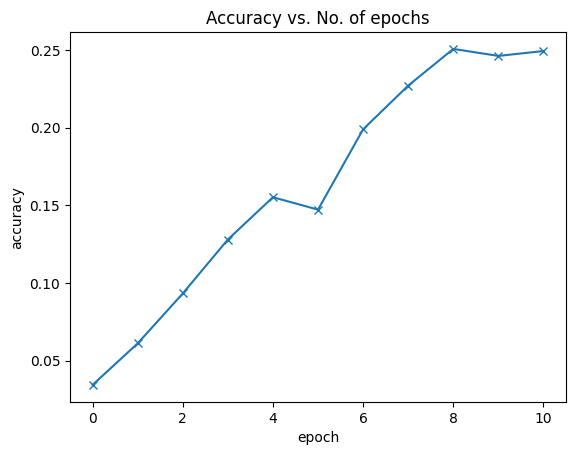

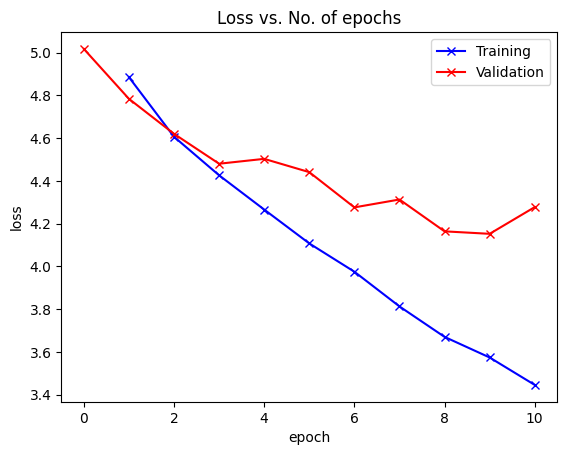

{'val_loss': 4.036308765411377, 'val_acc': 0.2662828862667084}

In [ ]:
#plot the output
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()
plot_accuracies(history)
plot_losses(history)
evaluate(model, test_loader)

In [ ]:
#measure the efficiency
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
num_classes = 151
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.70G
